# Моделирование при проектировании информационных систем

### Выполнила: Копосова Дарья Андреевна
### М9121-09.04.04рпис


# Прведем анализ первого датасета Medical Cost Personal Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Импорт библиотек для поискового анализа данных
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Импорт библиотек и модулей для предварительной обработки и машинного обучения
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import (
    GradientBoostingRegressor, 
    RandomForestRegressor, 
    AdaBoostRegressor
)
from sklearn.linear_model import SGDRegressor, LinearRegression
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Импорт библиотеки для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

# Функции

In [ ]:
# Функция для отображения точных значений на гистограммах
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height() * 0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height() * 0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

# Функция для отображения всех столбцов и строк
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 50
    display.max_rows = 100
    display.max_colwidth = 100
    display.width = None

# Функция для отображения распределения результатов по col (из списка columns_cat)
def display_distributions(feat):
    for col in columns_cat:
        sns.displot(data=insurance, x=feat, hue=col,
                    height=4, aspect=2, kind='kde')

        plt.title(f'Distribution of {feat} by {col}', size=18)
        plt.xlabel(feat, size=14)
        plt.ylabel('Count', size=14)
        plt.xticks(size=15)
        plt.show()

# Функция для отображения бокс-графиков подвига по col (из списка columns_cat)
def display_boxplots(feat):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns_cat):
        plt.subplot(2, 2, i + 1)
        ordre = insurance.groupby(col)[feat].median().sort_values(ascending=False).index
    
        sns.boxplot(x=feat, y=col, 
                    showfliers=True,
                    orient='h',
                    order=ordre,
                    data=insurance,
                    showmeans=True, # позволяет отображать среднее значение на коробочном графике
                    meanprops={"marker":"o",
                               "markerfacecolor":"white", 
                               "markeredgecolor":"black",
                               "markersize":"10"})

        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)
        plt.xlabel(" ", size=15)
        plt.ylabel(f"{col}", size=15)

        plt.title(f"{feat} by {col}", fontsize=18);

# Функция для отображения пленочного графика зарядов с различным оттенком
def display_lmplot(hue):
    for col in columns_quant:
        sns.lmplot(data=insurance,
                   x=col, y="charges", hue=hue,
                   height=4, aspect=2)
        plt.xlabel(col, fontsize=16)
        plt.ylabel("Charges", fontsize=16)
        plt.title(f"Charges by {col}", fontsize=18)

# Функция для отображения сводных графиков для feat по категориальным признакам
def display_catplots(feat, title):
    for col in columns_cat:
        sns.catplot(data=insurance, x=feat, kind="count", hue=col,
                    height=3, aspect=2)
        plt.title(f"Count of {title} by {col}", fontsize=15);

# Создать функции для предварительной обработки набора данных "страхование"

# Удалите дублированные строки в daaframe df
def drop_duplicates(df):
    df = df.drop(df[df.duplicated()].index)
    
    return df

# Закодируйте "регион" и "дочерние элементы" в виде нескольких двоичных столбцов
def one_hot_encoder(df):
    df = pd.get_dummies(
        df, 
        columns = ["region", "children"],
        drop_first=True
    )
    
    return df

# Закодируйте "курильщик" и "пол" в один двоичный столбец
def label_encoder(df):
    df[['smoker', 'sex']] = df[['smoker', 'sex']].apply(LabelEncoder().fit_transform)
    
    return df

# Стандартизировать количественные характеристики "возраст" и "ИМТ"
def standardizer(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df[['age', 'bmi']])
    df[['age', 'bmi']] = scaler.transform(df[['age', 'bmi']])
    
    return df

# Предварительно обработайте фрейм данных df с помощью всех вышеперечисленных функций
# Затем верните матрицы X и y
def preprocessing(df):
    df = drop_duplicates(df)
    df = one_hot_encoder(df)
    df = label_encoder(df)
    df = standardizer(df)
    
    X = df.drop('charges', axis=1)
    y = df['charges']
    
    print("shape of X:", X.shape)
    print("shape of y:", y.shape)
    
    return X, y
        
# Создайте функцию для оценки различных моделей
# с кривой обучения (применяя перекрестную проверку)
def evaluate_models(algorithm, X, y):
    
    # Кривая обучения
    N, train_score, val_score = learning_curve(
        algorithm, X, y,
        cv=5, scoring='r2',
        train_sizes=np.linspace(0.1, 1, 10)
    )
    
    # Постройте кривую обучения
    plt.figure(figsize=(8, 3))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='val_score')
    plt.legend()
    plt.title(f'{algorithm}', fontsize=18)
    
    train_scores.append(train_score[-1].mean())
    val_scores.append(val_score[-1].mean())
    
    # Распечатайте результаты
    print(f'{algorithm}')
    print("train_score =", "%0.3f" % train_score[-1].mean())
    print("val_score =", "%0.3f" % val_score[-1].mean())
    plt.show()
    print("-"*20)

    
# Функция для прогнозирования расходов для различных моделей
def predict_charges(algorithm):
    model = algorithm
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

# Функция для визуализации различий между y_test и y_pred
def compare_test_and_pred(y_pred, model_name):
    x_ax = range(len(y_test))
    fig = plt.figure(figsize=(18,5))
    plt.plot(x_ax, y_test, label="original", linewidth=1)
    plt.plot(x_ax, y_pred, label="predicted", linewidth=1)
    plt.title(f"Charges : test and predicted data - {model_name}", fontsize=20)
    plt.xlabel('X-axis', fontsize=15)
    plt.ylabel('Y-axis', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
    plt.grid(True)
    plt.show()

# Загрузка набора данных

In [ ]:
insurance = pd.read_csv('/content/drive/MyDrive/Магистратура /Обработка данных/insurance.csv')

In [ ]:
# Создайте копию набора данных "страхование"
insurance_copy = insurance.copy()

In [ ]:
# Отобразить все столбцы и строки
set_pandas_display_options()

In [ ]:
# Просмотр первых строк набора данных
insurance.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

# Исследовательский Анализ Данных

## Анализ формы

In [ ]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
# Форма наборов данных
print(f'Insurance dataset contains {insurance.shape[0]} records and {insurance.shape[1]} columns.')

Insurance dataset contains 1338 records and 7 columns.


In [ ]:
insurance.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [ ]:
insurance.dtypes.value_counts()

object     3
int64      2
float64    2
dtype: int64

In [ ]:
# Количество дублированных записей в наборе данных
print('Number of duplicates in Insurance dataset:', insurance.duplicated().sum())

Number of duplicates in Insurance dataset: 1


In [ ]:
# Удалите дублированную строку из набора данных
insurance = insurance.drop(insurance[insurance.duplicated()].index)

In [ ]:
# Отсутствующие значения в наборе данных 
print(f'Insurance NaNs')
print('-'*20)
print(insurance.isna().sum())

Insurance NaNs
--------------------
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


## Анализ целевого столбца : charges

In [ ]:
# Вывести статистические значения столбца 'charges'
round(insurance['charges'].describe(), 2)

count     1337.00
mean     13279.12
std      12110.36
min       1121.87
25%       4746.34
50%       9386.16
75%      16657.72
max      63770.43
Name: charges, dtype: float64

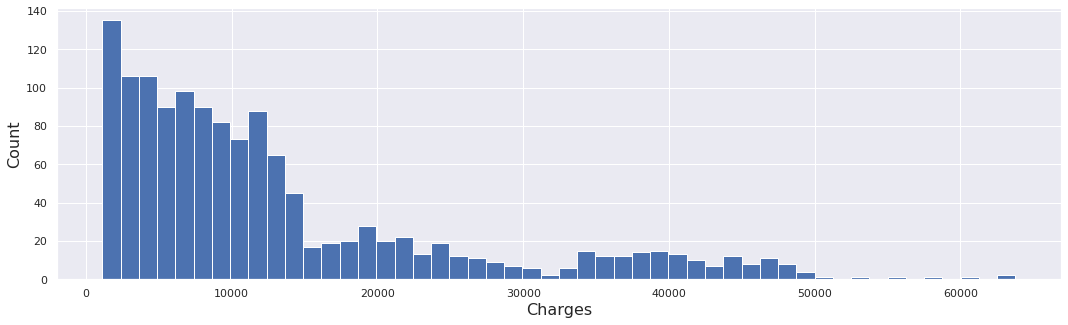

In [ ]:
# График распределения столбца 'charges'
sns.set_theme()
plt.figure(figsize=(18, 5))
plt.hist(insurance['charges'], bins=50)
plt.xlabel("Charges", fontsize=16)
plt.ylabel("Count", fontsize=16);

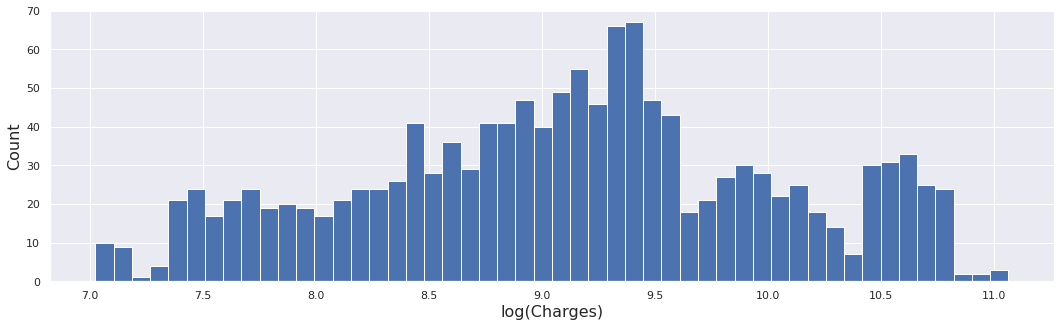

In [ ]:
# Распределительный участок log(charges)
plt.figure(figsize=(18, 5))
plt.hist(np.log(insurance['charges']), bins=50)
plt.xlabel("log(Charges)", fontsize=16)
plt.ylabel("Count", fontsize=16);

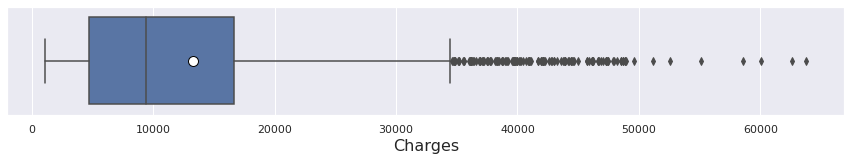

In [ ]:
sns.set(rc={"figure.figsize":(15, 2)})
sns.boxplot(data=insurance, x='charges',
            showmeans=True, # Отобразить среднее значение на прямоугольном графике
            meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                       "markersize":"10"})
plt.xlabel("Charges", fontsize=16);

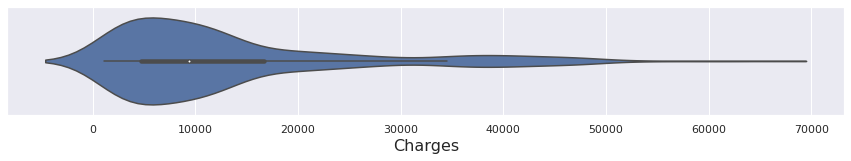

In [ ]:
sns.set(rc={"figure.figsize":(15, 2)})
sns.violinplot(data=insurance, x='charges')
plt.xlabel("Charges", fontsize=16);

## Анализ категориальных признаков :'sex', 'children', 'smoker' & 'region'

In [ ]:
# Список категориальных признаков
columns_cat = ['sex', 'smoker', 'region', 'children']

In [ ]:
# Подсчитайте количество каждой категории в columns_cat
for col in columns_cat:
    print(f'Count of Each Class in {col} \n' + '-'*20)
    print(insurance[col].value_counts())
    print(' '*20)
    print('*'*20)

Count of Each Class in sex 
--------------------
male      675
female    662
Name: sex, dtype: int64
                    
********************
Count of Each Class in smoker 
--------------------
no     1063
yes     274
Name: smoker, dtype: int64
                    
********************
Count of Each Class in region 
--------------------
southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64
                    
********************
Count of Each Class in children 
--------------------
0    573
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64
                    
********************


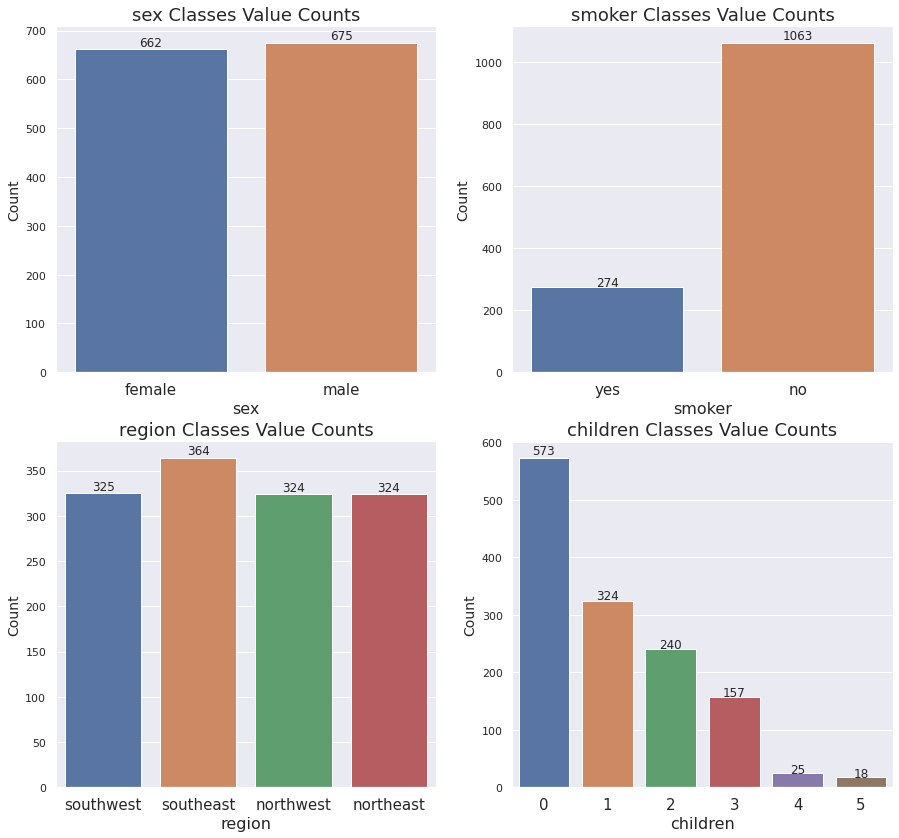

In [ ]:
# Визуализируйте количество значений для каждой категории в columns_cat
plt.figure(figsize=(15, 14))
for i, col in enumerate(columns_cat):
    plt.subplot(2, 2, i + 1)
    sns.set_theme(style='darkgrid')

    g = sns.countplot(x=col, data=insurance)

    plt.title(f'{col} Classes Value Counts', size=18)
    plt.xlabel(col, size=14)
    plt.ylabel('Count', size=14)
    plt.xticks(size=15)
    plt.xlabel(col, fontsize=16)

    show_values(g);

## Анализ количественных характеристик :'age' & 'bmi'

In [ ]:
# Создайте список количественных столбцов
columns_quant = ['age', 'bmi']

In [ ]:
# Распечатайте статистические значения
insurance[columns_quant].describe()

age          bmi
count  1337.000000  1337.000000
mean     39.222139    30.663452
std      14.044333     6.100468
min      18.000000    15.960000
25%      27.000000    26.290000
50%      39.000000    30.400000
75%      51.000000    34.700000
max      64.000000    53.130000

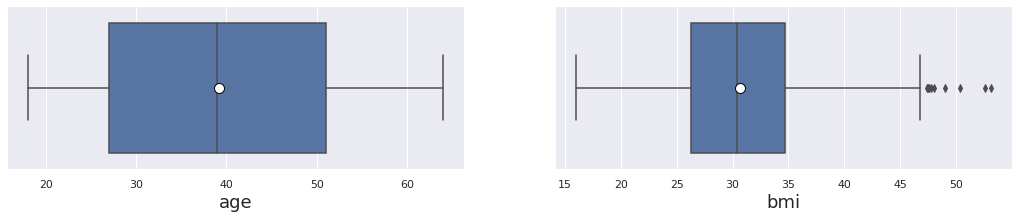

In [ ]:
# диаграммы для каждого количественного столбца
plt.figure(figsize=(18, 3))
for i, col in enumerate(columns_quant):
    plt.subplot(1, 2, i+1)
    sns.boxplot(data=insurance, x=col,
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white",
                           "markeredgecolor":"black",
                           "markersize":"10"})
    plt.xlabel(col, fontsize=18)

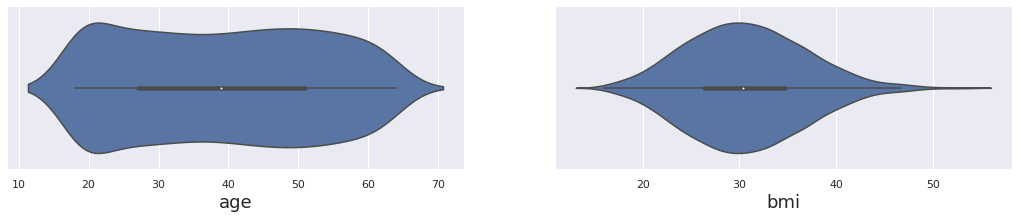

In [ ]:
plt.figure(figsize=(18, 3))
for i, col in enumerate(columns_quant):
    plt.subplot(1, 2, i+1)
    sns.violinplot(data=insurance, x=col)
    plt.xlabel(col, fontsize=18)

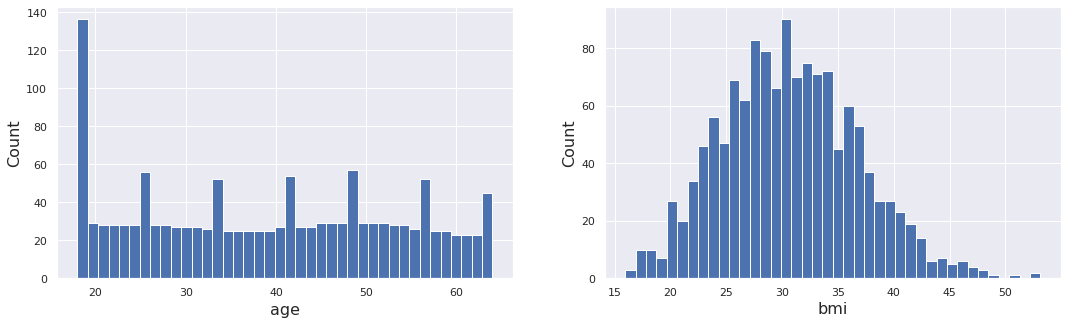

In [ ]:
plt.figure(figsize=(18, 5))
for i, col in enumerate(columns_quant):
    plt.subplot(1, 2, i+1)
    plt.hist(insurance[col], bins=40)
    plt.xlabel(col, fontsize=16)
    plt.ylabel("Count", fontsize=16)

## Анализ целевых / категориальных признаков отношения

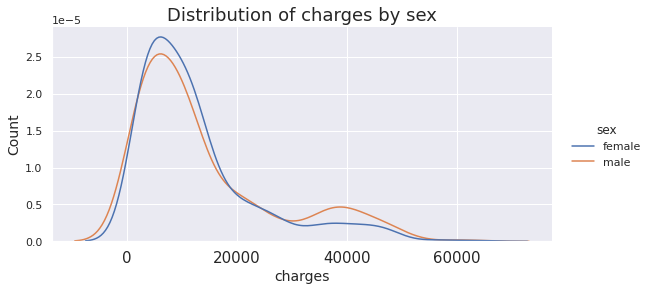

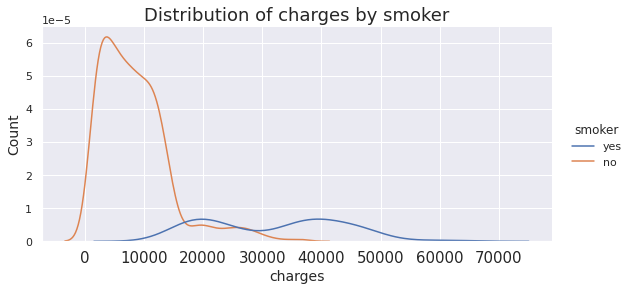

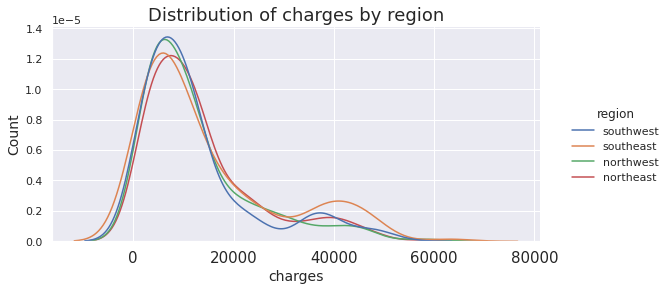

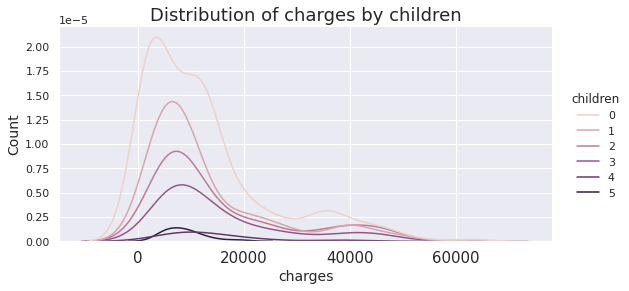

In [ ]:
# Цель распределения (сборы) / категориальные характеристики
display_distributions(feat="charges")

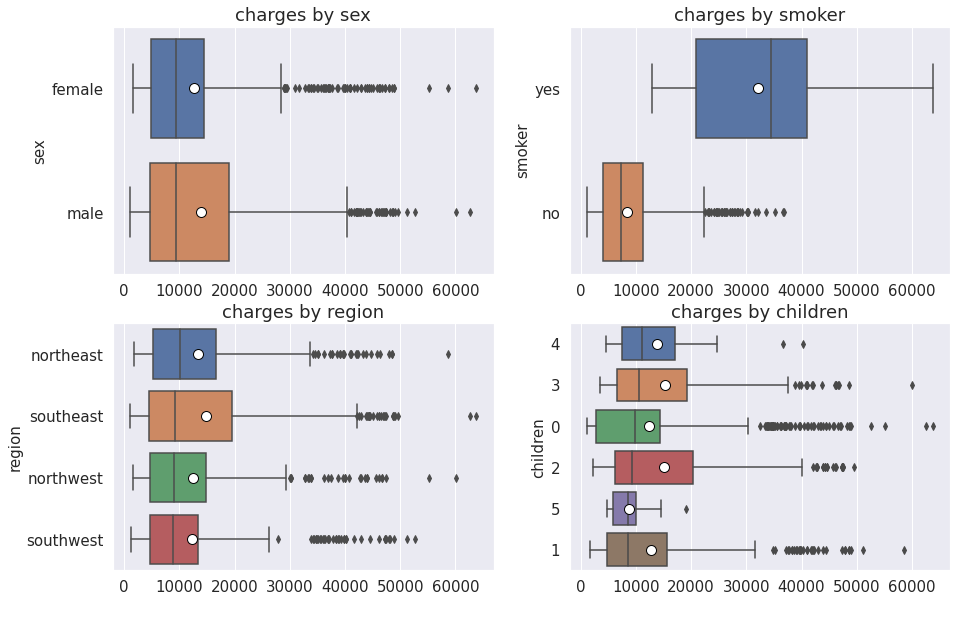

In [ ]:
#по категориальным признакам
display_boxplots(feat="charges")

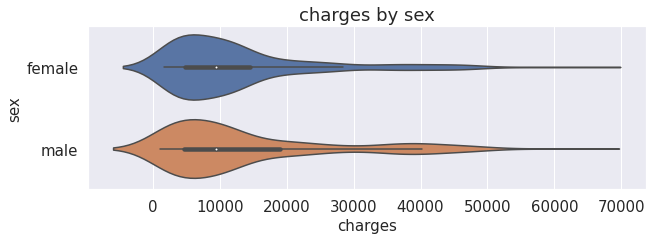

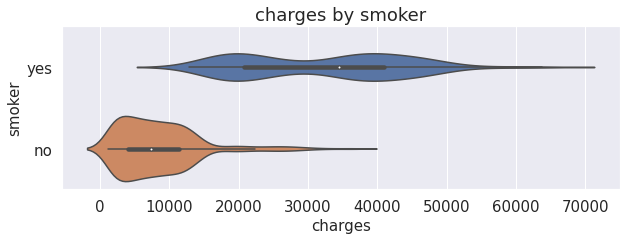

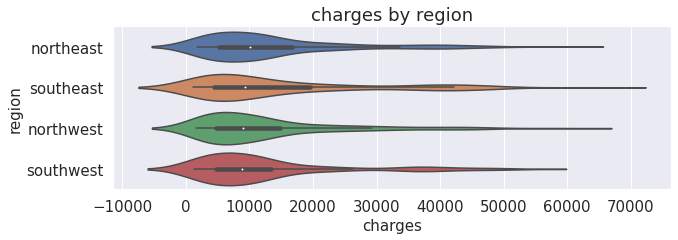

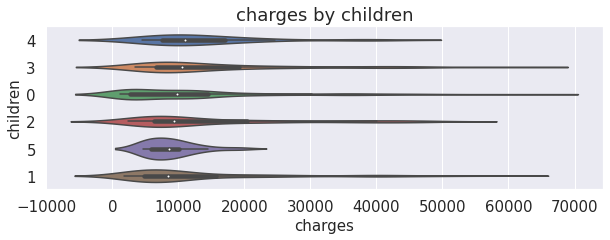

In [ ]:
for col in columns_cat:
    ordre = insurance.groupby(col)['charges'].median().sort_values(ascending=False).index

    plt.figure(figsize=(10,3))
    sns.violinplot(x="charges", y=col,
                   orient='h',
                   order=ordre,
                   data=insurance)

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel("charges", size=15)
    plt.ylabel(f"{col}", size=15)

    plt.title(f"charges by {col}", fontsize=18);

## Анализ целевых/ количественных характеристик отношения

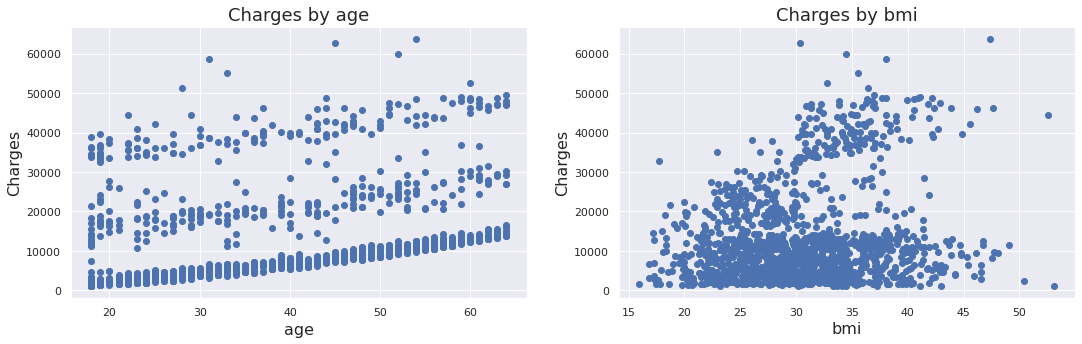

In [ ]:
# Целевой / категориальный признак
plt.figure(figsize=(18, 5))
for i, col in enumerate(columns_quant):
    plt.subplot(1, 2, i+1)
    plt.scatter(insurance[col], insurance['charges'])
    plt.xlabel(col, fontsize=16)
    plt.ylabel("Charges", fontsize=16)
    plt.title(f"Charges by {col}", fontsize=18)

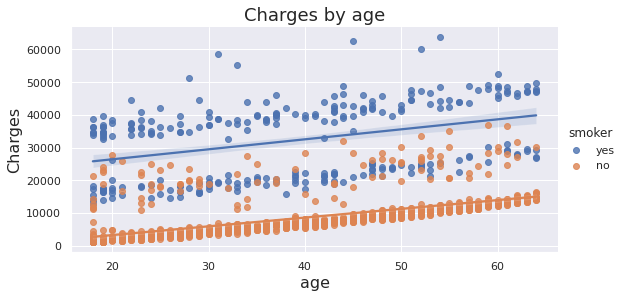

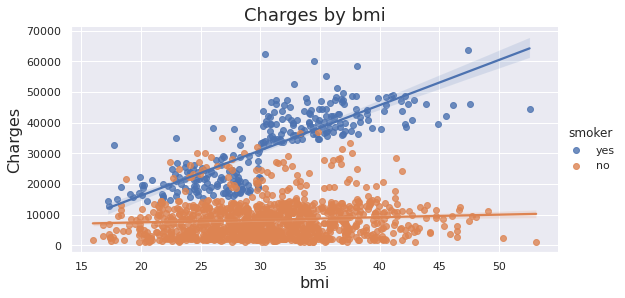

In [ ]:
# Целевая / категориальная характеристика курильщика
display_lmplot(hue="smoker")

**-> Цена страховки линейно увеличивается с возрастом**\
**-> Есть две группы людей в зависимости от значения ИМТ: люди с ИМТ > 30 платят намного больше, чем люди с ИМТ < 30**

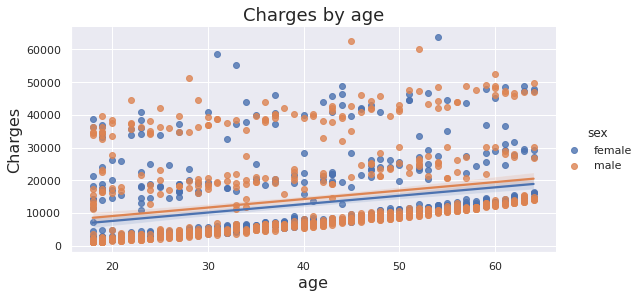

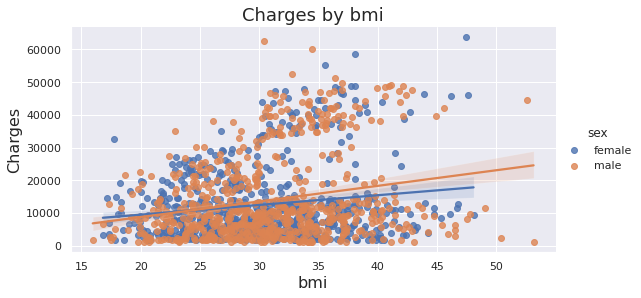

In [ ]:
# Целевой / категориальный признак по полу
display_lmplot(hue="sex")

**-> пол не оказывает большого влияния на цену страховки**

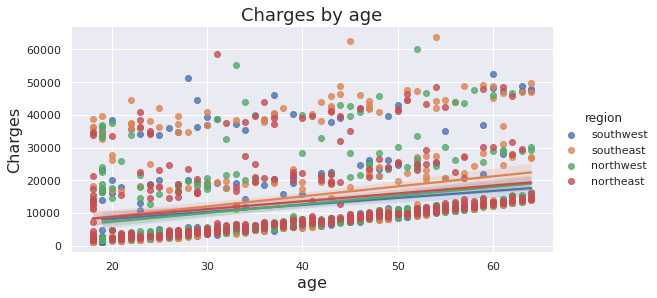

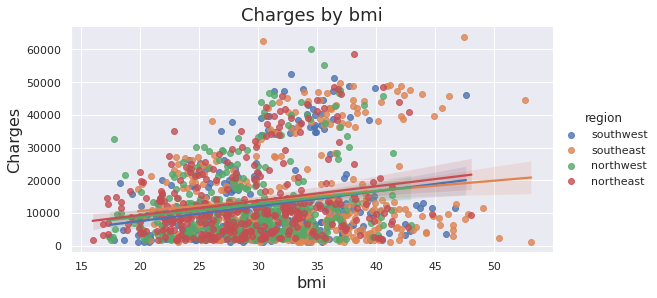

In [ ]:
# Целевой / категориальный признак по регионам
display_lmplot(hue="region")

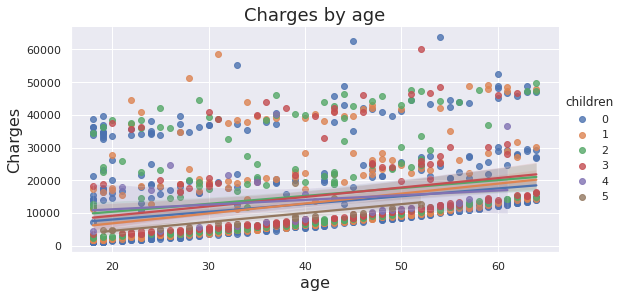

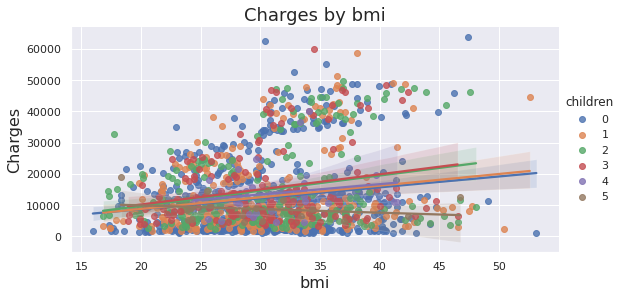

In [ ]:
# Целевая / категориальная характеристика детей
display_lmplot(hue="children")

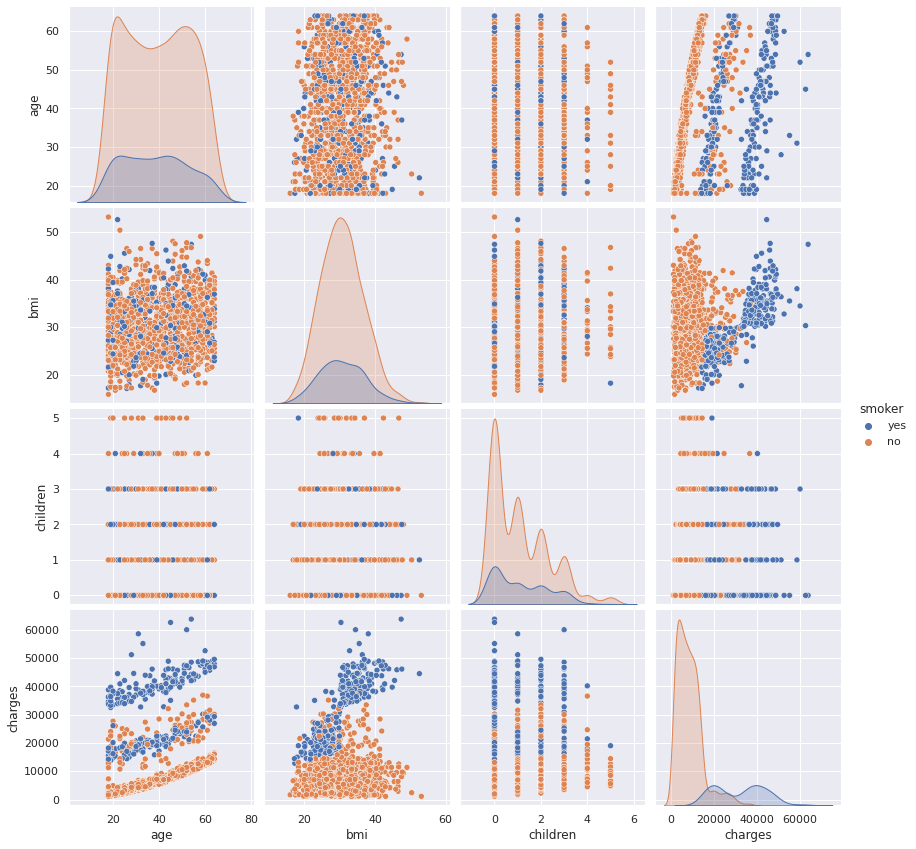

In [ ]:
# Парный план курильщика для возобновления всех отношений
sns.pairplot(insurance, hue='smoker',
             height=3, aspect=1);

## Анализ количественных признаков отношения / категориальных признаков

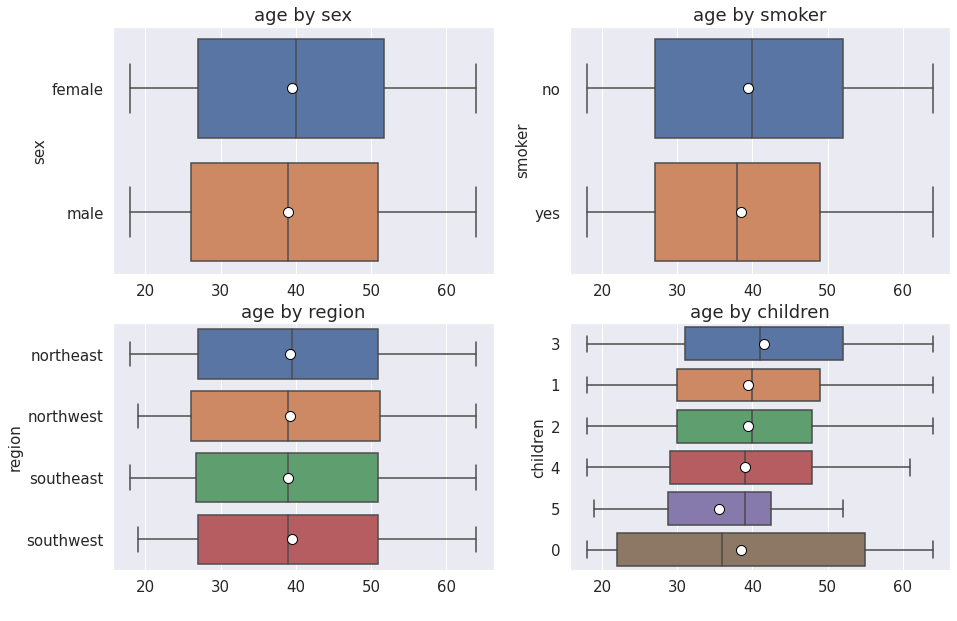

In [ ]:
display_boxplots(feat="age")

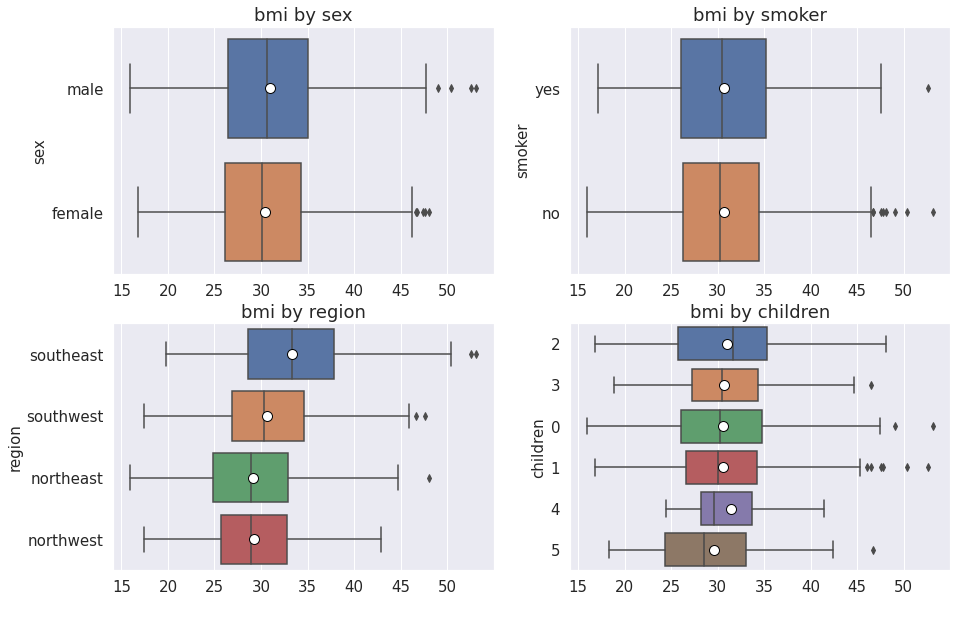

In [ ]:
display_boxplots(feat="bmi")

**-> ИМТ выше в юго-восточном регионе. Это может объяснить, почему цена страховки немного выше для людей, живущих там.**

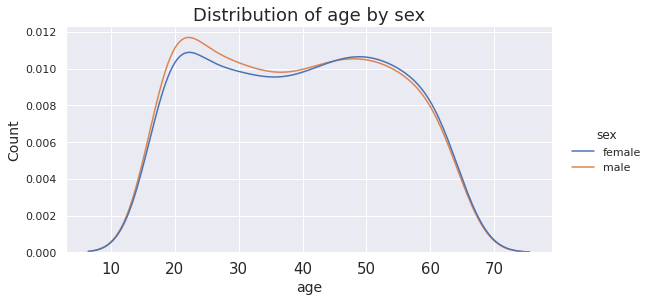

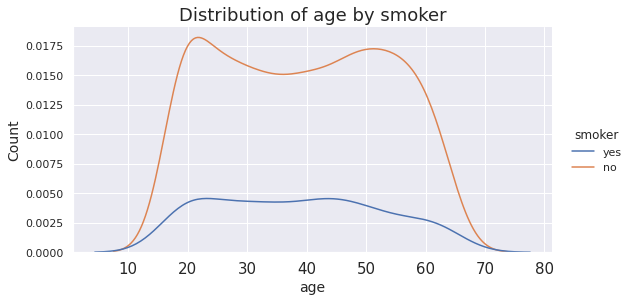

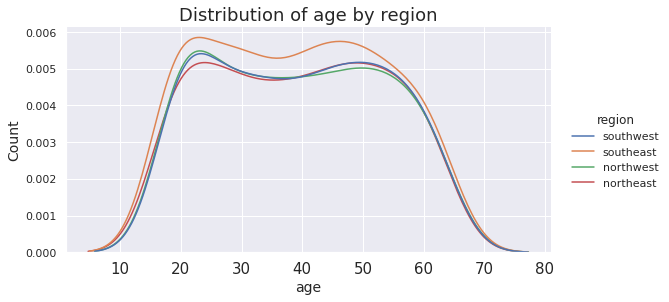

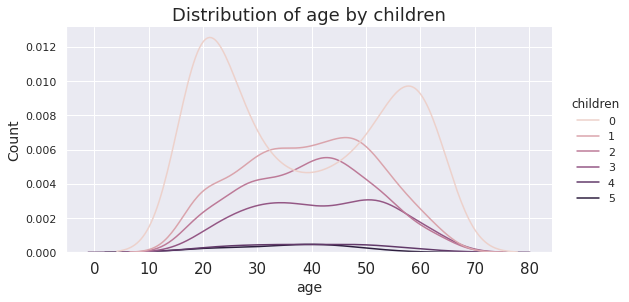

In [ ]:
# Распределение по возрасту / категориальным признакам
display_distributions(feat="age")

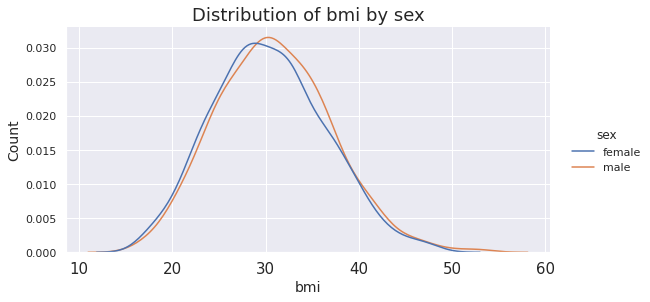

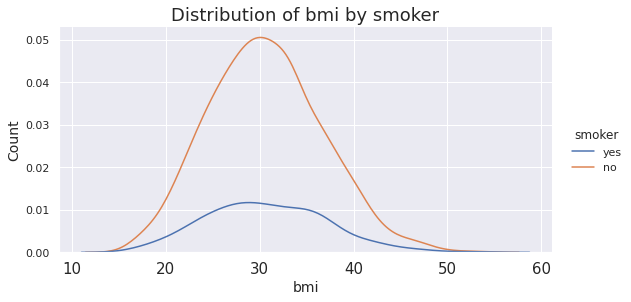

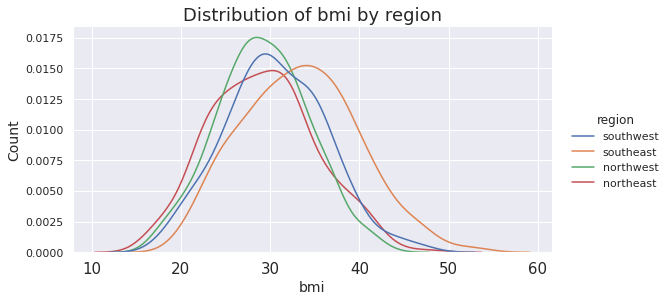

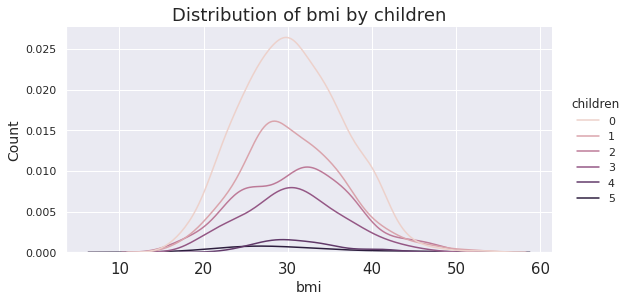

In [ ]:
# Распределение по возрасту / категориальным признакам
display_distributions(feat="bmi")

## Анализ категориальных признаков отношения / категориальные признаки

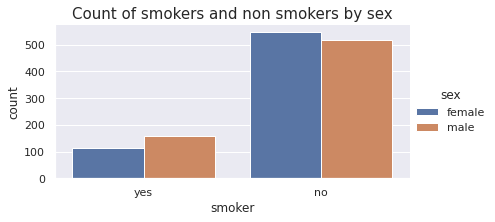

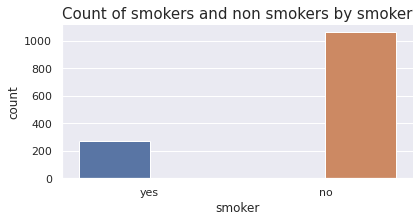

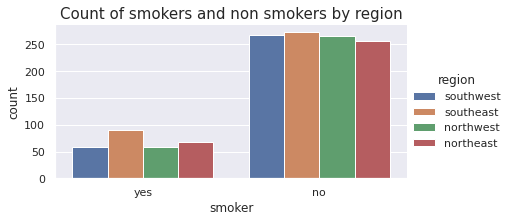

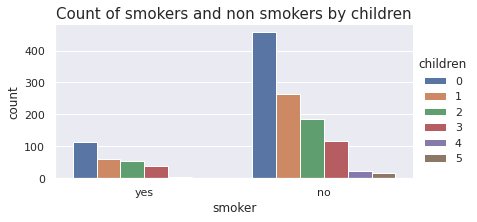

In [ ]:
# Категориальные заговоры для курильщиков/некурящих
display_catplots(feat="smoker", title="smokers and non smokers")

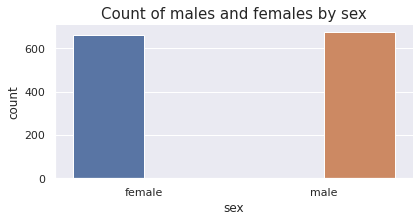

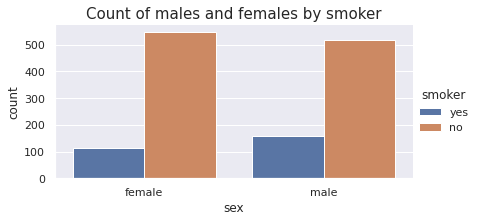

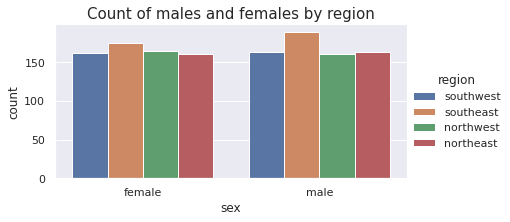

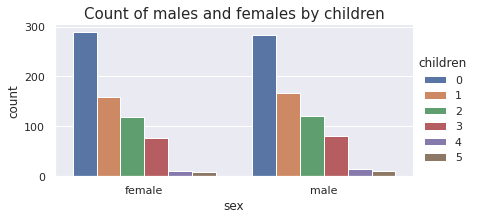

In [ ]:
# Категориальные  для мужчин/женщин
display_catplots(feat="sex", title="males and females")

## Корреляции между функциями и целью

In [ ]:
# Ярлык кодирует категориальные признаки "пол" и "курильщик"
# Действительно, эти две функции имеют только 2 категории 
insurance[['smoker', 'sex']] = insurance[['smoker', 'sex']].apply(LabelEncoder().fit_transform)

In [ ]:
# Корреляция между расходами и характеристиками
# (за исключением регионов, которые не могут быть закодированы метками)
round(insurance.corr()[['charges']].sort_values(by='charges', 
                                                ascending=False), 3)

charges
charges     1.000
smoker      0.787
age         0.298
bmi         0.198
children    0.067
sex         0.058

- функция "smoker" сильно коррелирует с целевыми "charges"
- характеристики "age" и "bmi" слабо коррелируют с целевыми "charges"
- характеристики "дети" и "пол" слабо коррелируют с целевыми "обвинениями"


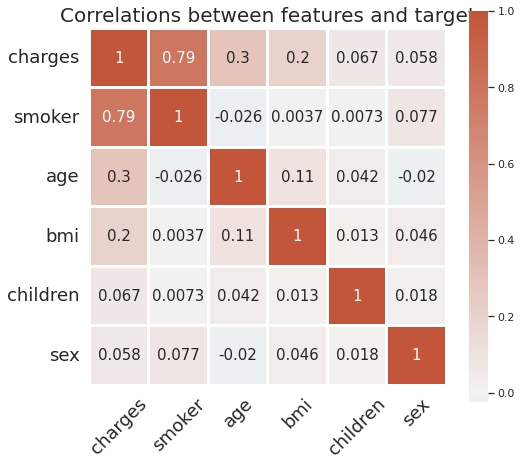

In [ ]:
# вычислить корреляционную матрицу
columns_corr = ['charges', 'smoker', 'age', 'bmi', 'children', 'sex']
corr = insurance[columns_corr].corr()

# Настройте фигуру matplotlib
f, ax = plt.subplots(figsize=(8,8))

# Создайте пользовательскую расходящуюся цветовую карту
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# тепловая карта с маской и правильным соотношением сторон
colormap = sns.heatmap(corr, 
                       annot=True,
                       annot_kws ={'size':15},
                       cmap=cmap, 
                       vmax=1, 
                       center=0,
                       square=True, 
                       linewidths=2, 
                       cbar_kws={"shrink": .9})

colormap.set_xticklabels(colormap.get_xmajorticklabels(), fontsize=18, rotation=45)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), fontsize=18, rotation=0)

plt.title('Correlations between features and target', size = 20);

- ** за исключением цели, функции плохо коррелируют друг с другом**

# Машинное обучение

## Предварительная обработка

In [ ]:
# Создайте матрицу X и y из набора данных insurance_copy
X, y = preprocessing(insurance_copy)

shape of X: (1337, 12)
shape of y: (1337,)


## Моделирование и сравнение различных типов алгоритмов

In [ ]:
# Создайте список алгоритмов для сравнения
algorithms = [GradientBoostingRegressor(),
              SGDRegressor(),
              LinearRegression(),
              LGBMRegressor(),
              RandomForestRegressor(),
              KNeighborsRegressor(),
              DecisionTreeRegressor(),
              AdaBoostRegressor()]

GradientBoostingRegressor()
train_score = 0.902
val_score = 0.854


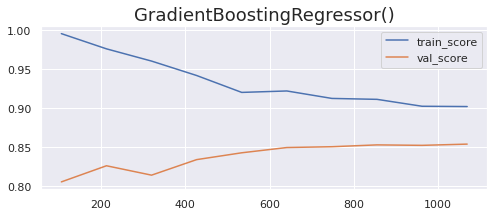

--------------------
SGDRegressor()
train_score = 0.752
val_score = 0.746


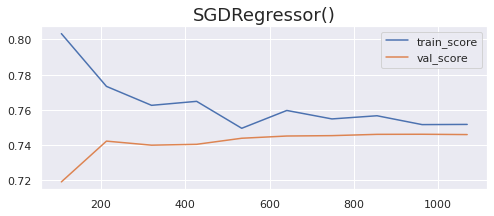

--------------------
LinearRegression()
train_score = 0.752
val_score = 0.746


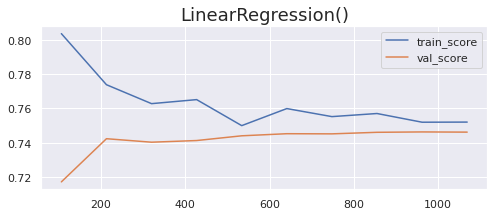

--------------------
LGBMRegressor()
train_score = 0.942
val_score = 0.838


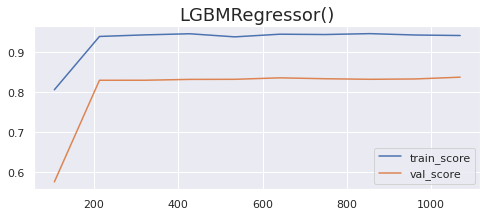

--------------------
RandomForestRegressor()
train_score = 0.976
val_score = 0.829


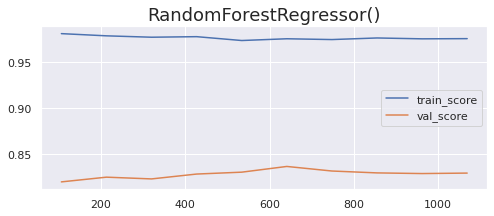

--------------------
KNeighborsRegressor()
train_score = 0.793
val_score = 0.670


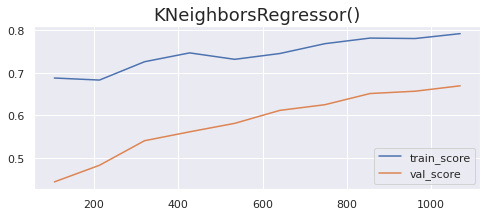

--------------------
DecisionTreeRegressor()
train_score = 0.999
val_score = 0.683


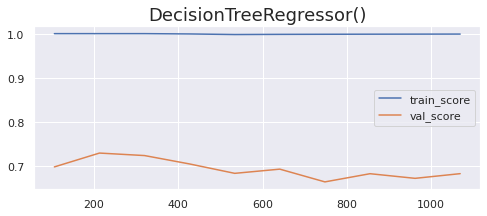

--------------------
AdaBoostRegressor()
train_score = 0.819
val_score = 0.804


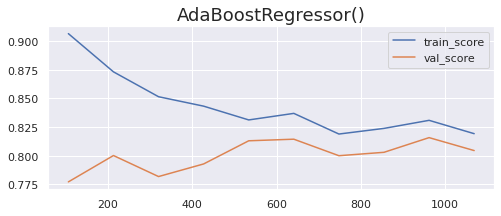

--------------------


In [ ]:
# Оцените различные модели и покажите кривые обучения
# для сравнения результатов обучения и результатов валидации
# и проверьте переоснащение
train_scores = []
val_scores = []

for a in algorithms:
    evaluate_models(a, X, y)

In [ ]:
# Создайте список названий моделей
models_names = ['GradientBoostingRegressor',
                'SGDRegressor',
                'LinearRegression',
                'LGBMRegressor',
                'RandomForestRegressor',
                'KNeighborsRegressor',
                'DecisionTreeRegressor',
                'AdaBoostRegressor']

In [ ]:
# Создать фрейм данных, содержащий оценки и названия моделей
scores = pd.DataFrame(
    {
        'model': models_names + models_names,
        'scores': train_scores + val_scores,
        'score_type': ['train'] * len(models_names) 
        + ['validation'] * len(models_names)
    }
)

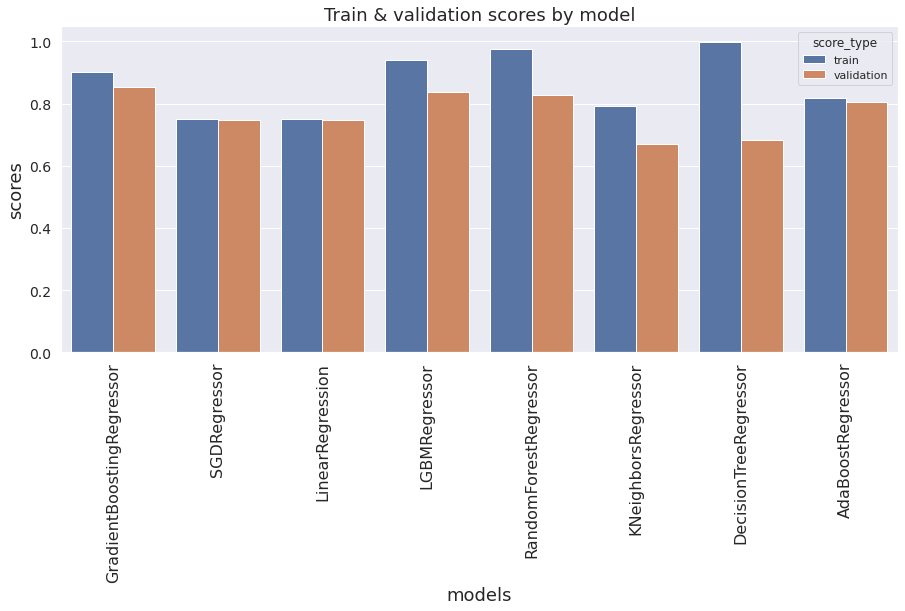

In [ ]:
sns.set()

# Создать сгруппированную столбчатую диаграмму
plt.figure(figsize=(15,6))
sns.barplot(x='model', y='scores', hue='score_type', data=scores)
plt.title('Train & validation scores by model', fontsize=18)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel("scores", fontsize=18)
plt.xlabel("models", fontsize=18);

- ** Лучшей моделью является GradientBoostingRegressor, поскольку она дает наилучший результат проверки**

# Визуализируйте и сравнивайте прогнозы между различными моделями

In [ ]:
# Создать обучающий набор  и тестовый набор (тестовый набор = 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, 
    random_state=42, stratify=X['smoker']
)

In [ ]:
# Прогнозируйте расходы с помощью различных моделей
models_and_pred_charges = {}
for a, m in zip(algorithms, models_names):
    y_pred = predict_charges(a)
    models_and_pred_charges[m] = y_pred

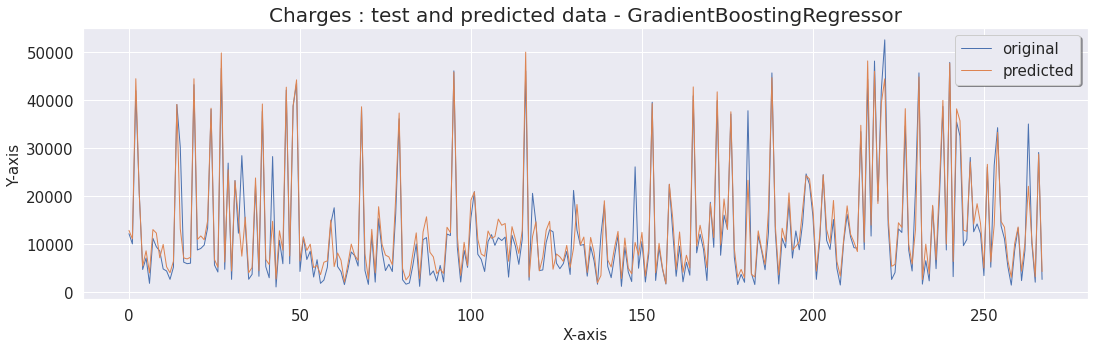

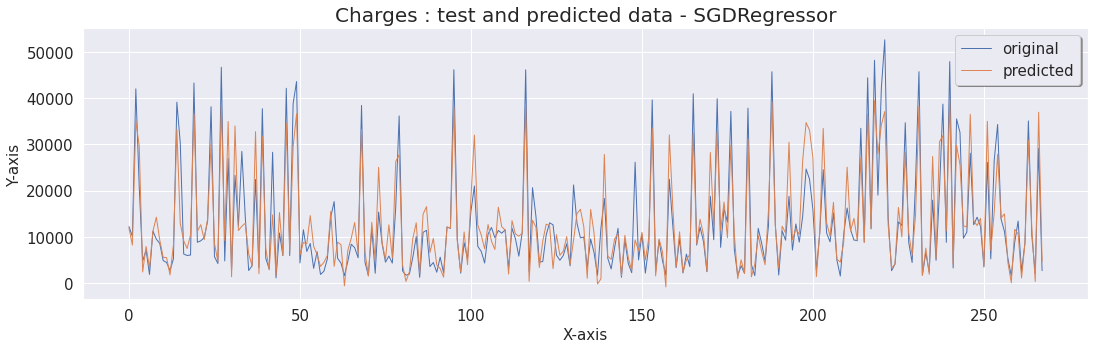

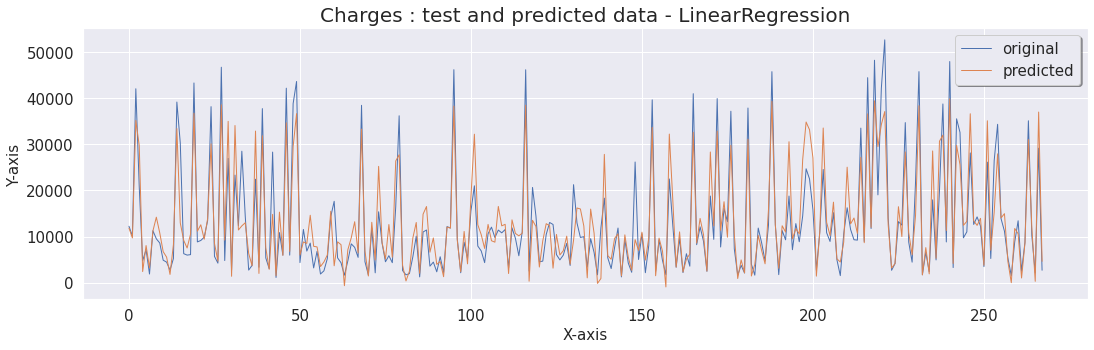

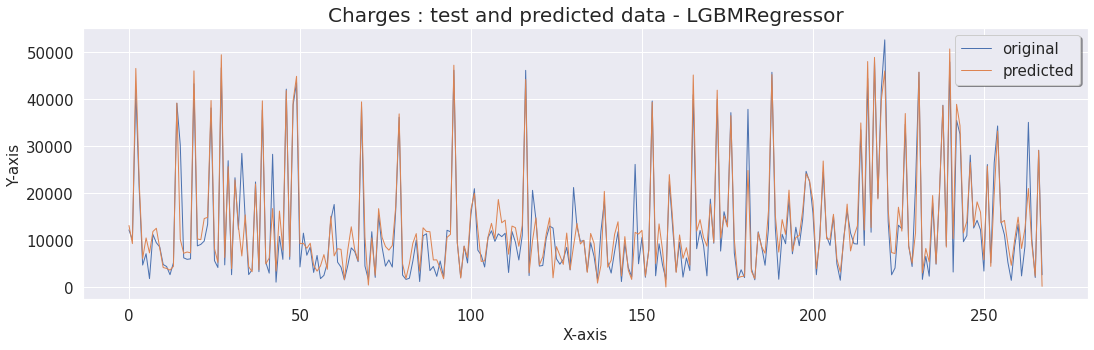

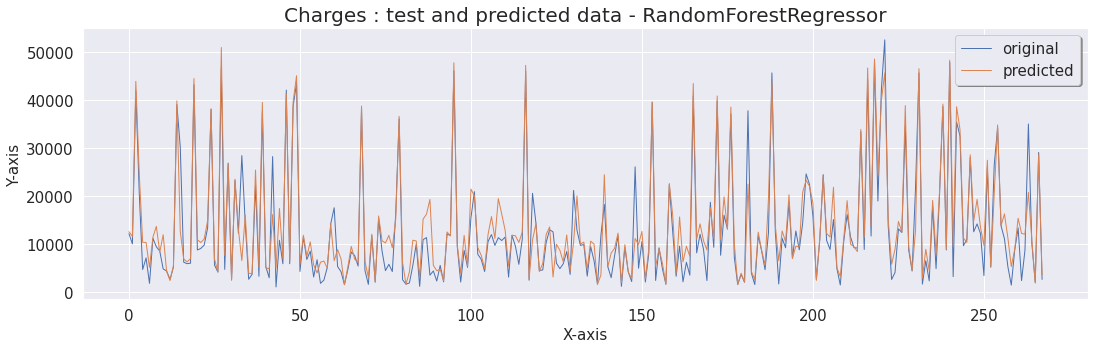

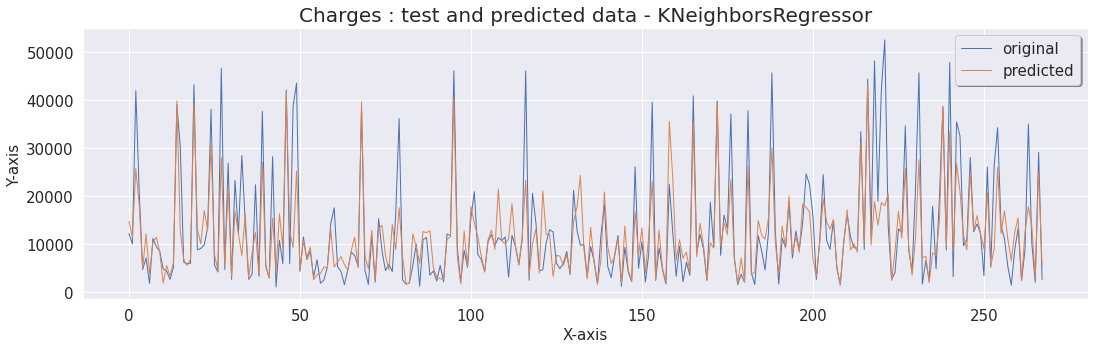

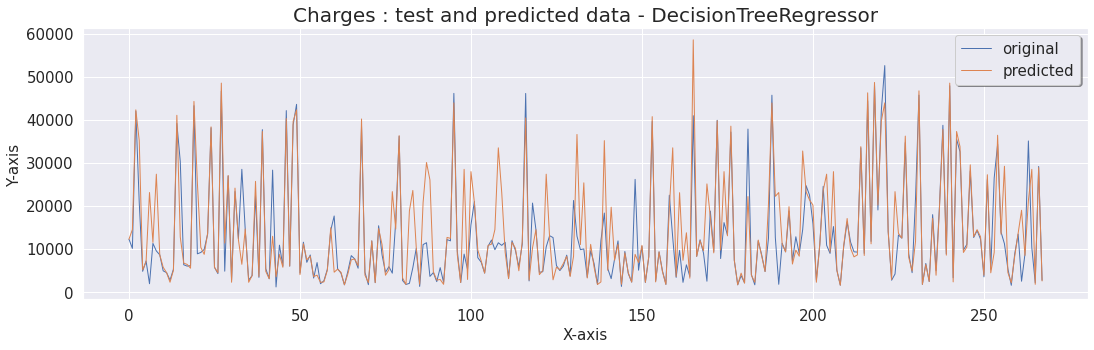

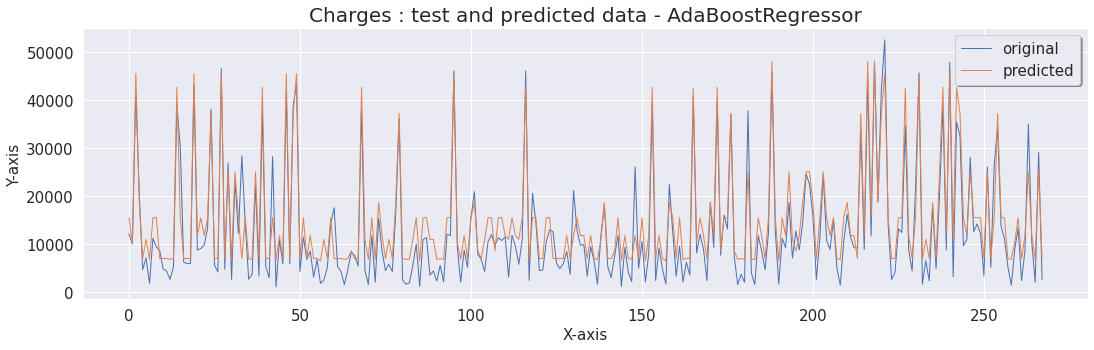

In [ ]:
# Сравните предсказания алгоритмов
for k, v in zip(models_and_pred_charges.keys(), models_and_pred_charges.values()):
    compare_test_and_pred(v, k)

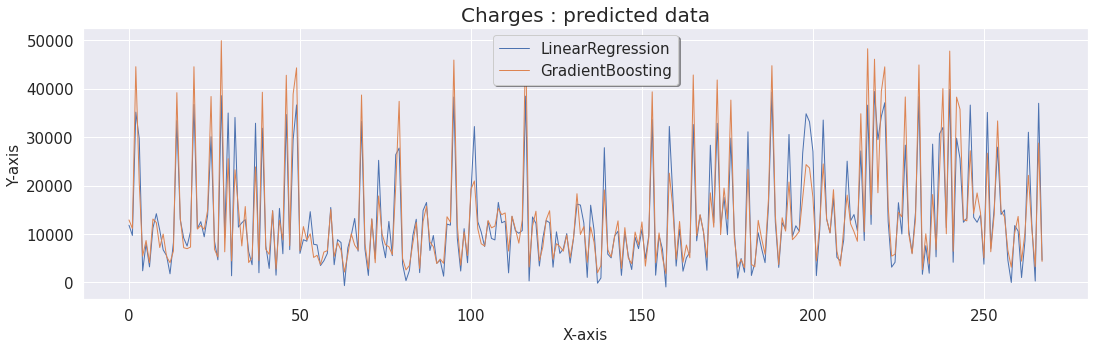

In [ ]:
# Сравните повышение градиента и линейную регрессию
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,5))
plt.plot(x_ax, 
         models_and_pred_charges['LinearRegression'],
         label="LinearRegression", linewidth=1)
plt.plot(x_ax, 
         models_and_pred_charges['GradientBoostingRegressor'],
         label="GradientBoosting",
         linewidth=1)
plt.title(f"Charges : predicted data", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

# Заключение

- GradientBoostingRegressor - это наиболее эффективная модель
- Модели могут быть оптимизированы путем выполнения дальнейшего проектирования функций